#  Medical Image Analysis in Blood cells

## By: Vishesh Kishore

#### White blood cell (WBCs) counting is an important indicator of health and is important for many blood-based diseases diagnostic tests. Currently, doctors utilize expensive automated counters like flow cytometers, or manually count blood cells on a microscope slide. Therefore, providing an automated way to detect and count WBCs would be advantageous. Detecting the WBC's and its subtypes is the first step for achieving this goal.

### CONTENT

For this problem we have dataset containing 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type). The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. This dataset is accompanied by an additional dataset containing the original 410 images (pre-augmentation) as well as two additional subtype labels (WBC vs WBC) and also bounding boxes for each cell in each of these 410 images (JPEG + XML metadata). More specifically, the folder 'dataset-master' contains 410 images of blood cells with subtype labels and bounding boxes (JPEG + XML), while the folder 'dataset2-master' contains 2,500 augmented images as well as 4 additional subtype labels (JPEG + CSV). There are approximately 3,000 augmented images for each class of the 4 classes as compared to 88, 33, 21, and 207 images of each in folder 'dataset-master'.

### Motivation
A computational grading of slides using deep learning techniques may help to make a pre-screening of hundreds or thousands of slides before Human verification.

## 1. Importing Libraries and modules

In [2]:

import numpy as np
import math, cv2, os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout


Using TensorFlow backend.


In [5]:
#cpu - gpu configuration

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [9]:
train_dataset_path="/TRAIN/"  
test_dataset_path="/TEST/"    
in_dir='/Users/visheshkishore/Desktop/Machine Learning Projects/HealthCare analysis Project/Blood Cell Classification/dataset2-master/dataset2-master/images/'
CATEGORIES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'] 

## 2. Plotting images using OpenCV

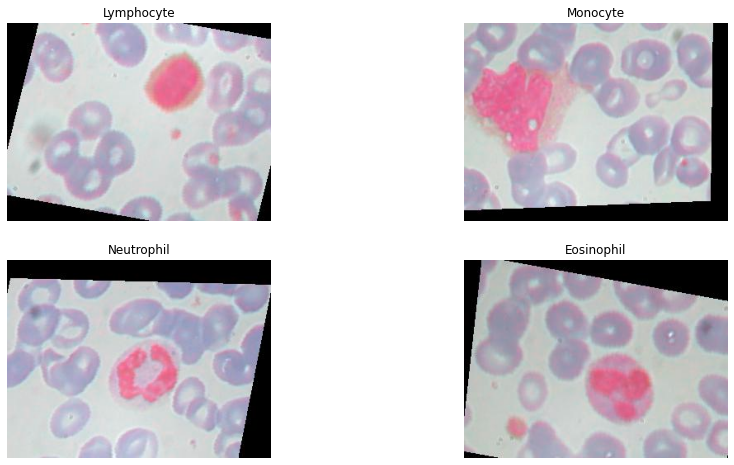

In [7]:
# Plot Image
def plotImage(image_path):  
    image = cv2.imread(image_path) 
    #image = image[:, :, [2, 1, 0]]  
    image=image.astype('float32') / 255 
    plt.imshow(image)  
    return

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.title('Lymphocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/LYMPHOCYTE/_0_204.jpeg'))
plt.subplot(222)
plt.title('Monocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/MONOCYTE/_0_9309.jpeg'))
plt.subplot(223)
plt.title('Neutrophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/NEUTROPHIL/_0_9742.jpeg'))
plt.subplot(224)
plt.title('Eosinophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/EOSINOPHIL/_5_907.jpeg'))

## 3. Summary of training samples 

In [10]:
print('Training samples:')
train_dir = os.path.join(in_dir, "TRAIN")  
num_samples = 0  
neutrophil = len(os.listdir(os.path.join(train_dir, "NEUTROPHIL")))
monocyte = len(os.listdir(os.path.join(train_dir, "MONOCYTE")))
lymphocyte = len(os.listdir(os.path.join(train_dir, "LYMPHOCYTE")))
eosinophil = len(os.listdir(os.path.join(train_dir, "EOSINOPHIL")))
print('Neutrophil: {}'.format(neutrophil))
print('MONOCYTE: {}'.format(monocyte))
print('LYMPHOCYTE: {}'.format(lymphocyte))
print('EOSINOPHIL: {}\n'.format(eosinophil))

#for testing data

# num_samples=0
# test_dir = os.path.join(in_dir, "TEST")
# for i in os.listdir(test_dir):
#   num_cells=len(os.listdir(os.path.join(test_dir,i)))
#   num_samples+=num_cells
#   print("cell:{:15s} num samples : {:d}".format(i,num_cells))
# print("total testing sample: {:d}\n".format(num_samples))  

Training samples:
Neutrophil: 2499
MONOCYTE: 2478
LYMPHOCYTE: 2483
EOSINOPHIL: 2497



## 4. Summary of testing samples

In [11]:
print('Testing samples:')
test_dir = os.path.join(in_dir, "TEST")
neutrophil_test = len(os.listdir(os.path.join(train_dir, "NEUTROPHIL")))
monocyte_test = len(os.listdir(os.path.join(train_dir, "MONOCYTE")))
lymphocyte_test = len(os.listdir(os.path.join(train_dir, "LYMPHOCYTE")))
eosinophil_test = len(os.listdir(os.path.join(train_dir, "EOSINOPHIL")))
print('NEUTROPHIL: {}'.format(neutrophil_test))
print('MONOCYTE: {}'.format(monocyte_test))
print('LYMPHOCYTE: {}'.format(lymphocyte_test))
print('EOSINOPHIL: {}'.format(eosinophil_test))

Testing samples:
NEUTROPHIL: 2499
MONOCYTE: 2478
LYMPHOCYTE: 2483
EOSINOPHIL: 2497


## 5. Image Processing

In [12]:
generator = ImageDataGenerator(
        rescale = 1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

### 5.1 Generating training data

In [13]:
train_dataset = generator.flow_from_directory(
    shuffle = True,
    batch_size = 32,
    target_size = (80, 80),
    directory = in_dir+train_dataset_path
)

Found 9957 images belonging to 4 classes.


### 5.2 Generating testing data

In [14]:
test_dataset = generator.flow_from_directory(
    shuffle = True,
    batch_size = 32,
    target_size = (80, 80),
    directory = in_dir+test_dataset_path
)

Found 2487 images belonging to 4 classes.


## 6. Building and Compiling the CNN Model

In [25]:
def model():
    model = Sequential()
    model.add(Conv2D(80, (3,3), strides = (1, 1), activation = 'relu', input_shape = (80, 80, 3)))
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu', input_shape = (80, 80, 3)))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(64, (3,3), strides = (1,1), activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])
    
    return model

nn = model()
history = nn.fit_generator(train_dataset, steps_per_epoch = 250, epochs = 20, verbose = 1, validation_data = test_dataset)

Epoch 1/20
250/250 [==============================] - 319s 1s/step - loss: 1.4286 - accuracy: 0.2659 - val_loss: 1.3688 - val_accuracy: 0.3542
Epoch 2/20
250/250 [==============================] - 300s 1s/step - loss: 1.3788 - accuracy: 0.3048 - val_loss: 1.5719 - val_accuracy: 0.3329
Epoch 3/20
250/250 [==============================] - 303s 1s/step - loss: 1.3065 - accuracy: 0.3735 - val_loss: 1.3501 - val_accuracy: 0.2984
Epoch 4/20
250/250 [==============================] - 301s 1s/step - loss: 1.1744 - accuracy: 0.4596 - val_loss: 1.0658 - val_accuracy: 0.5722
Epoch 5/20
250/250 [==============================] - 323s 1s/step - loss: 0.9667 - accuracy: 0.5717 - val_loss: 0.8300 - val_accuracy: 0.6441
Epoch 6/20
250/250 [==============================] - 317s 1s/step - loss: 0.8062 - accuracy: 0.6305 - val_loss: 0.6668 - val_accuracy: 0.6630
Epoch 7/20
250/250 [==============================] - 298s 1s/step - loss: 0.6623 - accuracy: 0.6940 - val_loss: 0.6934 - val_accuracy: 0.6904

## Summary of the CNN model

In [27]:
print(nn.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 78, 78, 80)        2240      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 76, 76, 64)        46144     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 36, 64)        36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

## Plotting the Train vs Test Accuracy curve

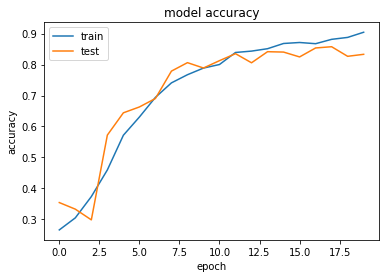

In [28]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
                                                 
plt.show() # to show the plot

## Plotting the train vs test loss 

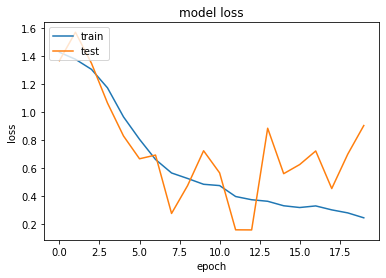

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 
                                                 
plt.show() # to show the plot

# Conclusion 

Our aim was to develop a deep learning model to identify four different types of White Blood cells found in humans that are Eosinophils , Monocytes , Lymphocytes and Neutrophils. Primary approach towards this problem was to develop a Convolutional Neural Network model that can classify blood smear slides into four categories mentioned above.Deep learning framework which we used for this problem was Keras.We used ImageDataGenerator class of Keras to load images directly from directory and for Image Preprocessing purposes like Rescaling.OpenCV was used to display the images and have a better intuition about the problem. A 4 layer deep CNN was implemented in which we used Dropout layers for regularization purpose to prevent overfitting. As being a multiclass classification problem we used softmax activation function in the last Dense layer followed by categorical_crossentropy as loss function and accuracy as classification metrics. 

